DODĚLAT:

Zhezčit Graf:
- procenta do vnitřního koláče
- zkusit u vnějšího koláče dát do labelů text i procenta

Vybírat z definition podle států


In [153]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import eurostat

In [154]:
# celá struktura pro Slovensko (mínus ty elektrárny)
definition = [
    {'code':'CRF2', # vnitřní graf, políčko 1                 PRŮMYSLOVÉ PROCESY
     'label':'Průmyslové procesy (výroba cementu, oceli...)',
     'sum':['CRF2'],                                     
     'color': '#ddddd',
     'breakdown': [
         {'code':'CRF2C', # vnější graf políčko 1.1
          'label':'Zpracování oceli a kovů',
          'sum':['CRF2C']}, 
         {'code':'CRF2A', # vnější graf políčko 1.2
          'label':'Minerální produkce (cement, vápno...)',
          'sum':['CRF2A']},
         {'code':'CRF2B', # vnější graf políčko 1.3
          'label':'Chemický průmysl',
          'sum':['CRF2B']}, 
         {'code':'CRF2_dif', # vnější graf políčko 1.3 - rozdíl
          'label':'Další průmyslové procesy',
          'reminder':True}]},
    {'code':'CRF1A3_CRF1D1A', # vnitřní graf, políčko 2         DOPRAVA
     'label':'Doprava (včetně letecké)',                     
     'sum':['CRF1A3', 'CRF1D1A'],
     'color': '#ddddd',
     'breakdown': [
        {'code':'CRF1A3B1', # vnější graf políčko 2.1
         'label':'Osobní automobilová doprava',
         'sum':['CRF1A3B1']},
         {'code':'CRF1A3B2_CRF1A3B3', # vnější graf políčko 2.2
          'label':'Nákladní a autobusová doprava',
          'sum':['CRF1A3B2', 'CRF1A3B3']},
         {'code':'CRF1D1A_CRF1A3A', # vnější graf políčko 2.3
          'label':'Letecká doprava',
          'sum':['CRF1D1A','CRF1A3A']},
         {'code':'CRF1A3_dif', # vnější graf políčko 2.4 - rozdíl
          'label':'Jiná doprava',
          'reminder':True}]},
    {'code':'CRF1A2', # vnitřní graf, políčko 3                 SPALOVÁNÍ V PRŮMYSLU
     'label':'Spalování v průmyslu',                     
     'sum':['CRF1A2'],
     'color': '#ddddd',
     'breakdown': [  
        {'code':'CRF1A2A_CRF1A2B', # vnější graf políčko 3.1
         'label':'Spalování při zpracování oceli a kovů',
         'sum':['CRF1A2A','CRF1A2B']},   
        {'code':'CRF1A2_dil', # vnější graf políčko 3.2 - rozdíl
         'label':'Další spalování v průmyslu',
         'reminder':True}]},       
    {'code':'CRF1A1', # vnitřní graf, políčko 4                 ENERGETIKA
     'label':'Energetika',                     
     'sum':['CRF1A1'],
     'color': '#ddddd',
     'breakdown': [
        {'code':'CRF1A1C_CRF1A1B', # vnější graf políčko 4.1
         'label':'Rafinace, výroba a úprava paliv',
         'sum':['CRF1A1C','CRF1A1B']},   
        {'code':'CRF1A2_dif_X', # vnější graf políčko 4.2 - rozdíl
         'label':'Teplárny a elektrárny',
         'reminder':True}]},
    {'code':'CRF1A4', # vnitřní graf, políčko 5                 SPALOVÁNÍ V DOM, INST A ZEMĚĎ
     'label':'Spalování v domácnostech, institucích a zemědělství',
     'sum':['CRF1A4'],                                     
     'color': '#ddddd'}, 
    {'code':'CRF3', # vnitřní graf, políčko 6                   ZEMĚDĚLSTVÍ
     'label':'Zemědělství',
     'sum':['CRF3'],                                     
     'color': '#ddddd'}, 
    {'code':'CRF5', # vnitřní graf, políčko 7                   ODPADOVÉ HOSPODÁŘSTVÍ
     'label':'Odpadové hospodářství',
     'sum':['CRF5'],                                     
     'color': '#ddddd'}, 
   {'code':'TOTAL_DIF', # vnitřní graf, políčko 8                   JINÉ   
    'label':'Jiné',                                    
    'color': '#ddddd', 
    'reminder':True}
]
                

Zadej stát a rok

In [155]:
YEAR = 2018 
STATE = 'SK'  

Dataframe z eurostatu

In [156]:
df = eurostat.get_data_df('env_air_gge')

In [157]:
# Pandas query() does not allow backslash in column names so "rename column" is needed. 
df = df.rename(columns={'geo\\time': 'geo'}) 

In [158]:
df2 = df.query("airpol == 'GHG' and geo == @STATE and unit == 'MIO_T'") 

In [159]:
df2 = df2[["src_crf", YEAR]] # jen kod odvětví a rok
df2 = df2.set_index('src_crf') # src_crf jako index

Funkce

In [160]:
def get_value(key, df): # získej hodnotu. Zadej klíč a df
    return df.loc[key, YEAR]

def get_sum(keys, df):
    sum = 0
    for key in keys:
        sum+= get_value(key, df)
    return sum

In [161]:
# Computes the sum values and a reminder.
def add_sums_and_reminder(definition, total_value_code, df):
    total_sum = 0
    for wedge_def in definition:
        if 'sum' in wedge_def:
            partial_sum = get_sum(wedge_def['sum'], df)
            df.loc[wedge_def['code'], YEAR] = partial_sum # přidá nový řádek ke stávajímu df
            total_sum += partial_sum
        elif 'reminder' in wedge_def:
            diff = get_value(total_value_code, df) - total_sum
            df.loc[wedge_def['code'], YEAR] = diff # přidá nový řádek ke stávajímu df

Volej funkci

In [162]:
add_sums_and_reminder(definition, 'TOTX4_MEMONIA', df2)

In [163]:
for wedge_def in definition:
    if 'breakdown' in wedge_def:
        add_sums_and_reminder(wedge_def['breakdown'], wedge_def['code'], df2)

Seznam kodů odvětví pro vnější a vnitřní graf a 
popisky pro vnější a vnitřní graf

In [164]:
# Seznam kodů odvětví pro vnější a vnitřní graf
inner_chart_structure = []
outer_chart_structure = []

for area in definition:
    inner_chart_structure.append(area['code']) 
    if 'breakdown' not in area:
        continue
    for subarea in area['breakdown']:
        outer_chart_structure.append(subarea['code'])

# Popisky pro vnější a vnitřní graf
inner_labels = []
outer_labels = []

for area in definition:
    inner_labels.append(area['label']) 
    if 'breakdown' not in area:
        continue
    for subarea in area['breakdown']:
        outer_labels.append(subarea['label'])        

Relativní dataframe pro vnější graf

In [165]:
# relativní dataframe vnějšího grafu se součtem pod 1. Abych dostal necelý vnější koláč
total = get_sum(inner_chart_structure, df2)
df_rel = df2.loc[outer_chart_structure]/total 

Graf

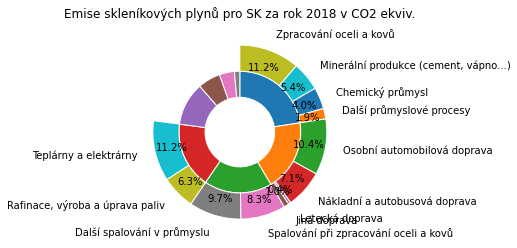

In [166]:
fig, ax = plt.subplots()
size = 0.3

# vnitřní
ax.pie(df2.loc[inner_chart_structure][YEAR], radius=1-size, counterclock=False, startangle=90, 
       wedgeprops=dict(width=size, edgecolor='w'))

# vnější
ax.pie(df_rel[YEAR], # tohle mi to řadí a 'YEAR' bere hodnoty ze sloupce YEAR
       radius=1, labels = outer_labels, counterclock=False, startangle=90, normalize = False,
       autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.2, wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title = f'Emise skleníkových plynů pro {STATE} za rok {YEAR} v CO2 ekviv.')

plt.show()